# Part 3 : H2O AutoML

#### In part 3 we will use h2o automl to get a better model than xgboost model from part 2 with minimal effort.

In [43]:
library(tidyverse)
library(tidymodels)
library(h2o)
library(tidyquant)

Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘package:h2o’:

    day, hour, month, week, year

The following object is masked from ‘package:base’:

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: quantmod
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
══ Need to Learn tidyquant? ════════════════════════════════════════════════════
Business Science offers a 1-hour course - Lea

In [2]:
df <- read_csv('telco_customer_churn.csv', col_types = cols(customerID = col_skip()))
df <- df %>% 
        mutate_if(is.character, as_factor) 
       #%>% mutate(Churn = Churn %>% fct_relevel('Yes'))
        
glimpse(df)

Observations: 7,043
Variables: 20
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fema…
$ SeniorCitizen    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Y…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, N…
$ tenure           <dbl> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, …
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes, …
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Yes,…
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber …
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No…
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No i…
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No i…
$ TechSupport      <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No int…
$ StreamingTV     

In [3]:
split_obj <- rsample::initial_split(df, prop = 0.8, strata = 'Churn')

train = rsample::training(split_obj)
test = rsample::testing(split_obj)

In [4]:
# We get vector of columns to drop from EDA done before.
drop_cols_2 <- readRDS('drop_cols_2.rds')

In [5]:
recipe_obj <- df %>% 
    recipe(Churn ~ ., data = df) %>%
    step_knnimpute(TotalCharges) %>% 
    step_YeoJohnson(all_numeric()) %>%
    step_center(all_numeric()) %>% 
    step_scale(all_numeric()) %>%
    step_mutate(SeniorCitizen = SeniorCitizen %>% as.numeric()) %>% 
    step_dummy(all_nominal(), -Churn, one_hot = T) %>% 
    step_rm(drop_cols_2)

In [6]:
train_processed <- recipe_obj %>% prep() %>% bake(train)
test_processed <- recipe_obj %>% prep() %>% bake(test)

train_processed %>% glimpse()

Observations: 5,636
Variables: 22
$ SeniorCitizen                           <dbl> -0.4398853, -0.4398853, -0.43…
$ tenure                                  <dbl> -1.6442229, 0.2971822, -1.495…
$ Churn                                   <fct> No, No, Yes, No, Yes, Yes, No…
$ gender_Male                             <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,…
$ Partner_Yes                             <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Dependents_Yes                          <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,…
$ PhoneService_Yes                        <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,…
$ MultipleLines_Yes                       <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,…
$ InternetService_DSL                     <dbl> 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,…
$ InternetService_Fiber.optic             <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,…
$ OnlineSecurity_No                       <dbl> 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,…
$ OnlineBackup_No                         <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,…
$ DeviceProtection

In [7]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpvbmQUE/h2o_arun_started_from_r.out
    /tmp/RtmpvbmQUE/h2o_arun_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 152 milliseconds 
    H2O cluster timezone:       Asia/Kolkata 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.28.0.2 
    H2O cluster version age:    2 months and 11 days  
    H2O cluster name:           H2O_started_from_R_arun_ryq920 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.45 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos

In [8]:
train_h2o <- as.h2o(train_processed)
test_h2o <- as.h2o(test_processed)

  |======================================================================| 100%
  |======================================================================| 100%


In [9]:
y <- "Churn"
x <- setdiff(names(train_h2o), y)

In [12]:
aml <- h2o.automl(x = x, y = y,
                  training_frame = train_h2o,
                  max_runtime_secs = 300,
                  nfolds = 5,
                  seed = 123)

  |======================================================================| 100%


In [14]:
typeof(aml)

[1] "S4"

In [15]:
slotNames(aml)

[1] "project_name"   "leader"         "leaderboard"    "event_log"     
[5] "modeling_steps" "training_info"

In [13]:
lb <- aml@leaderboard

In [16]:
leader <- aml@leader

In [17]:
lb

                                             model_id       auc   logloss
1 StackedEnsemble_BestOfFamily_AutoML_20200401_100733 0.8550052 0.4117551
2                        GLM_1_AutoML_20200401_100733 0.8549973 0.4049637
3    StackedEnsemble_AllModels_AutoML_20200401_100733 0.8545065 0.4117677
4      XGBoost_grid__1_AutoML_20200401_100733_model_3 0.8538660 0.4059231
5                    XGBoost_2_AutoML_20200401_100733 0.8533818 0.4067169
6      XGBoost_grid__1_AutoML_20200401_100733_model_7 0.8533351 0.4068310
      aucpr mean_per_class_error      rmse       mse
1 0.6761880            0.2350348 0.3634284 0.1320802
2 0.6788198            0.2289264 0.3617240 0.1308442
3 0.6761596            0.2322825 0.3636105 0.1322126
4 0.6762293            0.2365600 0.3623954 0.1313305
5 0.6753103            0.2391915 0.3628092 0.1316305
6 0.6750974            0.2410479 0.3628236 0.1316409

[35 rows x 7 columns] 

In [18]:
leader

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_AutoML_20200401_100733 
NULL


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.127841
RMSE:  0.3575486
LogLoss:  0.4006865
Mean Per-Class Error:  0.2176949
AUC:  0.8652151
AUCPR:  0.6995494
Gini:  0.7304303

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         No  Yes    Error        Rate
No     3295  845 0.204106   =845/4140
Yes     346 1150 0.231283   =346/1496
Totals 3641 1995 0.211320  =1191/5636

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.237758    0.658837 259
2                       max f2  0.120202    0.761878 327
3                 max f0point5  0.491669    0.665219 155
4                 max accuracy  0.452257    0.819375 170
5                max precision  0.917479    1.000000   0
6                   max recall  

In [33]:
# Saving the model
h2o.saveModel(leader, 'best_model')

[1] "/home/arun/Desktop/customer-churn/best_model/StackedEnsemble_BestOfFamily_AutoML_20200401_100733"

In [19]:
h2o.predict(leader, test_h2o)

  |======================================================================| 100%


  predict        No        Yes
1     Yes 0.4353673 0.56463267
2      No 0.9456354 0.05436457
3     Yes 0.6482346 0.35176544
4      No 0.9386605 0.06133948
5      No 0.9455691 0.05443093
6     Yes 0.6203880 0.37961197

[1407 rows x 3 columns] 

In [21]:
performance <- h2o.performance(leader, test_h2o)
performance

H2OBinomialMetrics: stackedensemble

MSE:  0.1488255
RMSE:  0.385779
LogLoss:  0.4548751
Mean Per-Class Error:  0.2550054
AUC:  0.820479
AUCPR:  0.6045753
Gini:  0.6409581

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        No Yes    Error       Rate
No     770 264 0.255319  =264/1034
Yes     95 278 0.254692    =95/373
Totals 865 542 0.255153  =359/1407

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.227274    0.607650 261
2                       max f2  0.099005    0.740582 340
3                 max f0point5  0.489748    0.594714 155
4                 max accuracy  0.580283    0.788202 125
5                max precision  0.910797    1.000000   0
6                   max recall  0.051001    1.000000 396
7              max specificity  0.910797    1.000000   0
8             max absolute_mcc  0.227274    0.444420 261
9   max min_per_class_accura

In [22]:
performance@metrics

$model
$model$`__meta`
$model$`__meta`$schema_version
[1] 3

$model$`__meta`$schema_name
[1] "ModelKeyV3"

$model$`__meta`$schema_type
[1] "Key<Model>"


$model$name
[1] "StackedEnsemble_BestOfFamily_AutoML_20200401_100733"

$model$type
[1] "Key<Model>"

$model$URL
[1] "/3/Models/StackedEnsemble_BestOfFamily_AutoML_20200401_100733"


$model_checksum
[1] "-845616816281189840"

$frame
$frame$name
[1] "test_processed_sid_be97_3"


$frame_checksum
[1] "-1132149805573181096"

$description
NULL

$scoring_time
[1] 1.58572e+12

$predictions
NULL

$MSE
[1] 0.1488255

$RMSE
[1] 0.385779

$nobs
[1] 1407

$custom_metric_name
NULL

$custom_metric_value
[1] 0

$r2
[1] 0.2361008

$logloss
[1] 0.4548751

$AUC
[1] 0.820479

$pr_auc
[1] 0.6045753

$Gini
[1] 0.6409581

$mean_per_class_error
[1] 0.2550054

$domain
[1] "No"  "Yes"

$cm
$cm$`__meta`
$cm$`__meta`$schema_version
[1] 3

$cm$`__meta`$schema_name
[1] "ConfusionMatrixV3"

$cm$`__meta`$schema_type
[1] "ConfusionMatrix"


$cm$table
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
        No Yes  Error          Rate
No     770 264 0.2553 = 264 / 1,034
Yes     95 278 0.2547 =    95 / 373
Totals 865 542 0.2552 = 359 / 1,407


$thresholds_and_metric_scores
Metrics for Thresholds: Binomial metrics as a function of classification thresholds
  threshold       f1       f2 f0point5 accuracy precision   recall specificity
1  0.910797 0.005348 0.003349 0.013263 0.735608  1.000000 0.002681    1.000000
2  0.907529 0.010667 0.006693 0.026247 0.736318  1.000000 0.005362    1.000000
3  0.905005 0.015957 0.010033 0.038961 0.737029  1.000000 0.008043    1.000000
4  0.900391 0.021220 0.013369 0.051414 0.737740  1.000000 0.010724    1.000000
5  0.897037 0.026385 0.016689 0.062972 0.737740  0.833333 0.013405    0.999033
  absolute_mcc min_per_class_accuracy mean_per_class_accuracy  tns fns fps tps
1     0.044403               0.002681                0.501340 1034 372   0   1
2     0.062818               0.005362                0.502681 1034 371   0   2
3     0.076963               0.008043                0.504021 1034 370   0   3
4     0.088901               0.010724                0.505362 1034 369   0   4
5     0.084248               0.013405                0.506219 1033 368   1   5
       tnr      fnr      fpr      tpr idx
1 1.000000 0.997319 0.000000 0.002681   0
2 1.000000 0.994638 0.000000 0.005362   1
3 1.000000 0.991957 0.000000 0.008043   2
4 1.000000 0.989276 0.000000 0.010724   3
5 0.999033 0.986595 0.000967 0.013405   4

---
    threshold       f1       f2 f0point5 accuracy precision   recall
395  0.051913 0.443914 0.665474 0.333035 0.337598  0.285495 0.997319
396  0.051367 0.435342 0.657709 0.325345 0.314144  0.278443 0.997319
397  0.051001 0.432715 0.655997 0.322832 0.304904  0.276092 1.000000
398  0.050655 0.427998 0.651642 0.318640 0.291400  0.272263 1.000000
399  0.050376 0.423383 0.647345 0.314556 0.277896  0.268539 1.000000
400  0.049941 0.419101 0.643325 0.310782 0.265103  0.265103 1.000000
    specificity absolute_mcc min_per_class_accuracy mean_per_class_accuracy tns
395    0.099613     0.163529               0.099613                0.548466 103
396    0.067698     0.131103               0.067698                0.532509  70
397    0.054159     0.122281               0.054159                0.527079  56
398    0.035783     0.098704               0.035783                0.517892  37
399    0.017408     0.068372               0.017408                0.508704  18
400    0.000000     0.000000               0.000000                0.500000   0
    fns  fps tps      tnr      fnr      fpr      tpr idx
395   1  931 372 0.099613 0.002681 0.900387 0.997319 394
396   1  964 372 0.067698 0.002681 0.932302 0.997319 395
397   0  978 373 0.054159 0.000000 0.945841 1.000000 396
398   0  997 373 0.035783 0.000000 0.964217 1.000000 397
399   0 1016 373 0.017408 0.000000 0.982592 1.000000 398
400   0 1034 373 0.000000 0.000000 1.000000 1.000000 399

$max_criteria_and_metric_scores
M

In [24]:
h2o.auc(performance)

[1] 0.820479

In [25]:
h2o.logloss(performance)

[1] 0.4548751

#### Our logloss is much better than the xgboost model we got in Part 2 which was 2.11

In [37]:
gains_lift_tbl <- h2o.gainsLift(performance)

In [39]:
gains_lift_tbl

group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
1,0.01066098,0.87343673,3.01769437,3.017694,0.80000000,0.88953581,0.8000000,0.8895358,0.032171582,0.03217158,201.769437,201.76944
2,0.02061123,0.85260358,3.23324397,3.121753,0.85714286,0.86219978,0.8275862,0.8763391,0.032171582,0.06434316,223.324397,212.17528
3,0.03056148,0.83982225,2.69436997,2.982605,0.71428571,0.84568087,0.7906977,0.8663574,0.026809651,0.09115282,169.436997,198.26049
4,0.04051173,0.83242928,2.69436997,2.911810,0.71428571,0.83541726,0.7719298,0.8587580,0.026809651,0.11796247,169.436997,191.18104
5,0.05046198,0.81739724,2.42493298,2.815806,0.64285714,0.82512277,0.7464789,0.8521257,0.024128686,0.14209115,142.493298,181.58064
6,0.10021322,0.73267139,2.47882038,2.648508,0.65714286,0.77506428,0.7021277,0.8138683,0.123324397,0.26541555,147.882038,164.85084
7,0.14996446,0.62930358,2.04772118,2.449195,0.54285714,0.68285845,0.6492891,0.7704053,0.101876676,0.36729223,104.772118,144.91951
8,0.20042644,0.52331349,2.07200846,2.354230,0.54929577,0.57681550,0.6241135,0.7216646,0.104557641,0.47184987,107.200846,135.42297
9,0.29992893,0.33504768,1.56273458,2.091648,0.41428571,0.42157346,0.5545024,0.6221083,0.155495979,0.62734584,56.273458,109.16483
10,0.40014215,0.21223683,1.28412526,1.889409,0.34042553,0.26876206,0.5008881,0.5336148,0.128686327,0.75603217,28.412526,88.94090


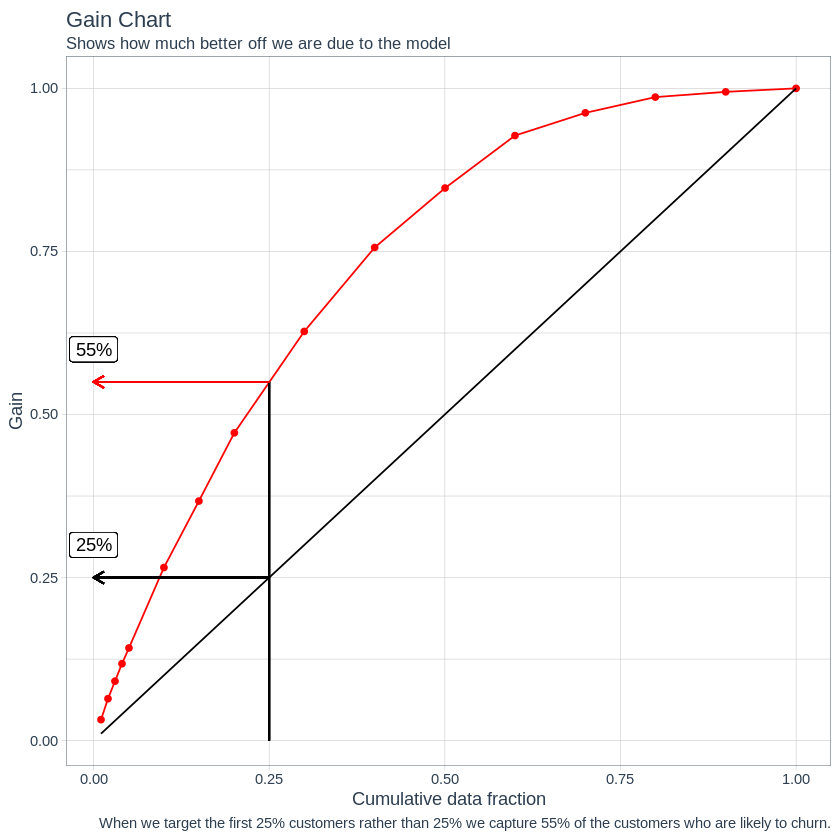

In [107]:
gain_chart <- gains_lift_tbl %>% 
    select(cumulative_data_fraction, cumulative_capture_rate) %>% 
    ggplot() +
    geom_line(aes(x = cumulative_data_fraction, y =cumulative_capture_rate), color = 'red') +
    geom_point(aes(x = cumulative_data_fraction, y =cumulative_capture_rate), color = 'red') +
    geom_line(aes(x = cumulative_data_fraction, y = cumulative_data_fraction)) +
    geom_segment(x = 0.25, y = 0, xend = 0.25, yend = 0.55) +
    geom_segment(x = 0.25, y = 0.55, xend = 0, yend = 0.55, color = 'red', arrow = arrow(length = unit(0.1, "inches"))) +
    geom_segment(x = 0.25, y = 0.25, xend = 0, yend = 0.25, arrow = arrow(length = unit(0.1, "inches"))) +
    geom_label(x = 0, y = 0.6, label = '55%') +
    geom_label(x = 0, y = 0.3, label = '25%') +
    theme_tq() +
    labs(title = 'Gain Chart',
         subtitle = 'Shows how much better off we are due to the model',
         x = 'Cumulative data fraction',
         y = 'Gain',
         caption = 'When we target the first 25% customers rather than 25% we capture 55% of the customers who are likely to churn.')

gain_chart

#### When we use the model to target customers instead of randomly targeting then we capture more churning customers with less resources. This leads to cost saving.

In [110]:
# We will save the plot
ggsave(filename = 'gain_chart.png', plot = gain_chart)

Saving 6.67 x 6.67 in image


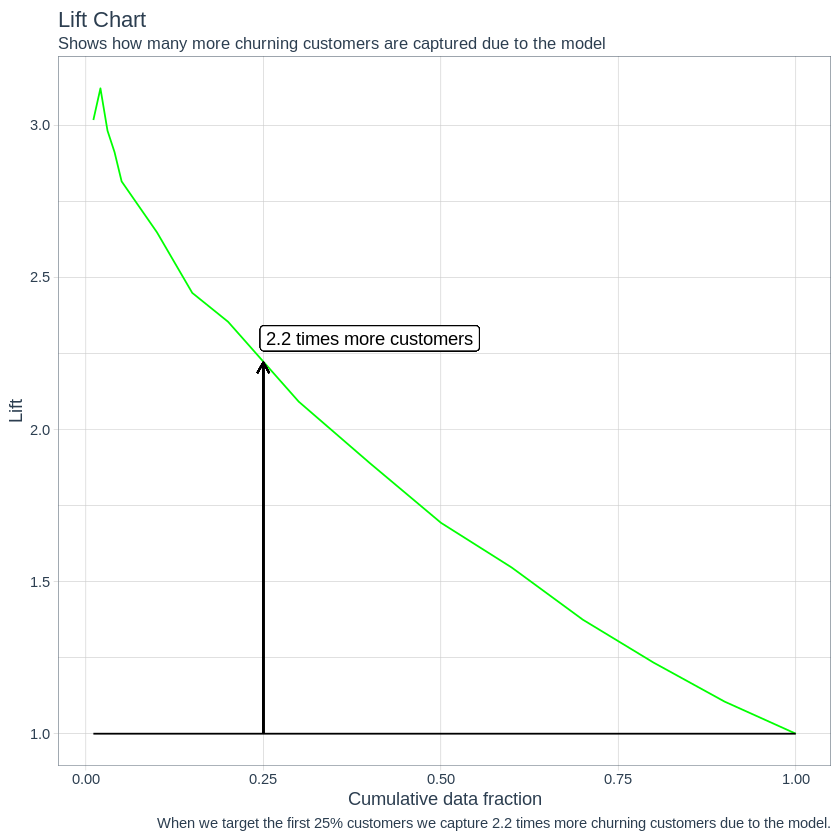

In [108]:
lift_chart <- gains_lift_tbl %>% 
    select(cumulative_data_fraction, cumulative_lift) %>% 
    ggplot() +
    geom_line(aes(x = cumulative_data_fraction, y =cumulative_lift), color = 'green') +
    geom_line(aes(x = cumulative_data_fraction), y = 1) +
    geom_segment(x = 0.25, y = 1, xend = 0.25, yend = 2.22, arrow = arrow(length = unit(0.1, "inches"))) +
    geom_label(x = 0.4, y = 2.3, label = '2.2 times more customers') +
    theme_tq() +
    labs(title = 'Lift Chart',
         subtitle = 'Shows how many more churning customers are captured due to the model',
         x = 'Cumulative data fraction', 
         y = 'Lift',
         caption = 'When we target the first 25% customers we capture 2.2 times more churning customers due to the model.')

lift_chart

#### Lift gives the same information in a different way. For the first 25% customers we captured 55% of the churning customers.
#### 55/25 = 2.2 which is the lift we got from the Lift chart.

In [111]:
# We will save the plot
ggsave(filename = 'lift_chart.png', plot = lift_chart)

Saving 6.67 x 6.67 in image
